Below are testing modules and other stuff

In [ ]:
#Loading nessesary libraries


import os
import random

from Bio import SeqIO
from IPython.display import display, Image

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import dmslogo

import seaborn as sns




In [ ]:
#Loading the data
#Here we are using the modified DMS_file containing different identifiers such as immunization, conditions and immunization status

fasta_file = r'c:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\RBD_wuhan.fasta'

# Read the FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    wuhan_sequence = str(record.seq)
    break  # Assuming there's only one sequence in the FASTA file


file_path = r'c:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\summary_DMS_cleaned.xlsx'

df_total = pd.read_excel(file_path, usecols=["DMS_RBD_AS_position", "Spike_AS_Position", "Count_of_Base", "Amino_Acid", "Type_of_Mutation", "Enrichment_Ratio", "barcode", "immunization", "condition", "Total_Reads"])

# Subtract 5 to every position of Spike_AS_Position. (In excel sheets this starts at 336, instead of 331) I could also just have fixed the excel sheets. 
df_total["Spike_AS_Position"] = df_total["Spike_AS_Position"] - 5

#Removing ~5000 datapoints with "inf" values in the Enrichment_Ratio column and discarding reads with less than 10.000 total reads
df_total = df_total.dropna(subset=['Enrichment_Ratio','Amino_Acid'])

df_total = df_total[df_total["Total_Reads"] > 10000]

immunization = "Wuhan_Sequence"
barcode = "Wuhan_Barcode"

data_wuhan = []
for position, amino_acid in enumerate(wuhan_sequence, start=1):
    data_wuhan.append({
        'DMS_RBD_AS_position': position,
        'Spike_AS_Position': position + 330,
        'Amino_Acid': amino_acid,
        'immunization': immunization,
        'barcode': barcode,
        'Enrichment_Ratio': 1,# Assuming an enrichment ratio of 1 for simplicity
    })

## Create a DataFrame
df_wuhan = pd.DataFrame(data_wuhan)


df_total = pd.concat([df_total, df_wuhan], ignore_index=True)



In [ ]:
#TESTING CODE FOR ONLY LOOKING AT ESCAPE MUTATIONS THAT PRODUCE NON-SYNOM MUTATIONS

df_escape = df_total[(df_total['Enrichment_Ratio'] < 1) & (df_total['Type_of_Mutation'] == 'NON-SYNOM')]

df_escape = df_escape[df_escape['Spike_AS_Position'] > 34+336] #Removes the first 34 positions due to bad read quality

df_escape['Enrichment_Ratio_inverted'] = df_escape['Enrichment_Ratio'].apply(lambda x: 1 / x if x != 0 else x)

#df_escape['Enrichment_Ratio_log2'] = df_escape['Enrichment_Ratio'].apply(lambda x: np.log2(x) if x > 0 else x)

df_escape_agg = df_escape.groupby(['Spike_AS_Position', 'Amino_Acid','immunization'], as_index=False).agg({
    'Enrichment_Ratio_inverted': 'sum'
})

df_escape_agg['Enrichment_Ratio_log2'] = df_escape_agg['Enrichment_Ratio_inverted'].apply(lambda x: np.log2(x) if x > 0 else x)

#The positions that have showed high enrichment ratios in the library droplets are discarded from the analysis (pos 33, 72, 81 and 151)
sites_to_show_escape = map(
    str,
    #[(i+336) for i in range(107, 114) if i not in [33, 72, 81, 151]] +
    [455, 456, 472, 473, 484, 485, 486, 490, 496, 499] + # RBD-ACE2 interface according to article
    list(range(394,414)) + # R21 peptide sequence with high affinity
    list(range(484, 503)) # R13 peptide sequence with high affinity
)
df_escape_agg = df_escape_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show_escape)
)

for immunization in df_escape_agg['immunization'].unique():
    print(immunization)
    df_filtered_escape = df_escape_agg.query(f'immunization == "{immunization}"')#.query("show_site")
    # Aggregate the data to ensure unique Spike_AS_Position values
    df_filtered_escape = df_filtered_escape.groupby('Spike_AS_Position', as_index=False).agg({
        'Enrichment_Ratio_log2': 'sum',
    }).drop_duplicates(subset=['Spike_AS_Position'])
    # Merge the show_site column back into df_filtered
    df_filtered_escape = df_filtered_escape.merge(df_escape_agg[['Spike_AS_Position', 'show_site']], on='Spike_AS_Position', how='left')
    
    # Ensure unique Spike_AS_Position values before reindexing
    df_filtered_escape = df_filtered_escape.drop_duplicates(subset=['Spike_AS_Position'])
    
    # Reindex to ensure sequential unbroken integers in Spike_AS_Position
    df_filtered_escape = df_filtered_escape.set_index('Spike_AS_Position').reindex(range(df_filtered_escape['Spike_AS_Position'].min(), df_filtered_escape['Spike_AS_Position'].max() + 1)).reset_index()
    df_filtered_escape['Enrichment_Ratio_log2'] = df_filtered_escape['Enrichment_Ratio_log2'].fillna(0)
    df_filtered_escape['show_site'] = df_filtered_escape['show_site'].fillna(False)
    
    fig, ax = dmslogo.line.draw_line(
        df_filtered_escape,
        x_col="Spike_AS_Position",
        height_col="Enrichment_Ratio_log2",
        title=immunization + ' lineplot',
        xlabel="Spike AA Position",
        ylabel="Enrichment Ratio log2",
        show_col="show_site"
    )
    
    # Save the figure
    #file_path = os.path.join(r"C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\DMS_plots\Escape", f"{immunization}_lineplots.png")
    #plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')
    #plt.close(fig)
    #plt.show()


In [ ]:

#Use this line to highlight areas of interest, and change alpha values to change transparency
df_escape_agg['shade_color'] = df_escape_agg['Spike_AS_Position'].apply(
    lambda x: 'green' if x in [408, 503, 505] else ('yellow' if 399 <= x <= 418 or 489 <= x <= 508 else 'none')
)
df_escape_agg['shade_alpha'] = df_escape_agg['Spike_AS_Position'].apply(
    lambda x: 0.3 if x in [408, 503, 505] else (0.15 if 399 <= x <= 418 or 489 <= x <= 508 else 0)
)


#Produces the plots for all barcodes in a given immunization group (Wildtype_RBD/Mutant_RBD/Neutralizing_Ab/Polyclonal_Ab)
for barcode in df_escape_agg['barcode'].unique():
    df_filtered = df_escape_agg.query(f'barcode == "{barcode}"').query("show_site").query("immunization == 'wildtype_RBD'")
    if not df_filtered.empty:
        fig, ax = dmslogo.draw_logo(
            df_filtered,
            x_col="Spike_AS_Position",
            letter_col="Amino_Acid",
            letter_height_col="Enrichment_Ratio_log2",
            title=barcode,
            addbreaks=True,
            shade_color_col="shade_color",
            shade_alpha_col="shade_alpha"
        )



#for barcode in df_escape_agg['immunization'].unique():
#    print(immunization)
#    fig, ax = dmslogo.draw_logo(
#        df_escape_agg.query(f'immunization == "{immunization}"').query("show_site"),
#        x_col="Spike_AS_Position",
#        letter_col="Amino_Acid",
#        letter_height_col="Enrichment_Ratio_log2",
#        title=immunization,
#        addbreaks=True
#    )


The following code will cluster the conditions based on the enrichment ratios between conditions. I.e if the variations in an RBD sequnce is more alike to one of the other conditions

Two things that i might consider doing: Seperating the RBD sequence into smaller sections, maybe 10-20 aminoacids, and then compare throughout the sequence. This can help identify what causes the clustering. 
Secondly clustering based on amount of substitutions. 
Thirdly, an option to cluster based on barcoding, and then possible labeling each barcode in a color based on the "immunization". In this way we can look at each condition and how this is contributing to the overall clustering

Should the library droplets be kept in there or should it just be all 1's. (I.e. comparing the Library used for enrichment_ratios against itself).

In [ ]:
#Loading in the nessecary libraries
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from skbio import DistanceMatrix
from skbio.tree import nj

df_sub_agg = df_total_agg.query('immunization != "Library_ctrl"')
pivot_df = df_sub_agg.pivot_table(index='site_label', columns='immunization', values='Enrichment_Ratio', aggfunc='mean')

pivot_df = pivot_df.fillna(0)

#Calculating the distance matrix based on the euclidean distance

dist_matrix = pdist(pivot_df.T, metric='euclidean')

#For better visualization
dist_square = squareform(dist_matrix)

#Clustering based on average linkage
linkage_matrix = linkage(dist_matrix, method='average')


plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=pivot_df.columns)
plt.title('Clustering based on enrichment ratios')
plt.xlabel('Condition')
plt.ylabel('Distance')
plt.show()

In [ ]:
#Testing to see if the data is clustering correctly based on condtitions (i.e. polyclonal antibody samples clustering together)

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from skbio import DistanceMatrix
from skbio.tree import nj

df_total_agg = df_total.groupby(['DMS_RBD_AS_position', 'Amino_Acid', 'immunization', 'barcode'], as_index=False).agg({
    'Enrichment_Ratio': 'sum'
})

sites_to_show = map(
    str,
    [i for i in range(25, 200) if i not in [33, 72, 81, 151]]
)


df_total_agg = df_total_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["DMS_RBD_AS_position"].astype(str),
    show_site=lambda x: x["DMS_RBD_AS_position"].astype(str).isin(sites_to_show)
)

# Filter for Polyclonal_Ab and Neutralizing_Ab
df_poly_agg = df_total_agg.query('immunization == "Polyclonal_Ab"')
df_neutralizing_agg = df_total_agg.query('immunization == "Neutralizing_Ab" | immunization == "Wuhan_Sequence"')


# Combine the data
df_combined = pd.concat([df_poly_agg, df_neutralizing_agg])

pivot_df = df_combined.pivot_table(index='site_label', columns='barcode', values='Enrichment_Ratio', aggfunc='mean')
pivot_df = pivot_df.fillna(0)

# Calculating the distance matrix based on the euclidean distance
dist_matrix = pdist(pivot_df.T, metric='euclidean')

# For better visualization
dist_square = squareform(dist_matrix)

# Clustering based on average linkage
linkage_matrix = linkage(dist_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=pivot_df.columns)
plt.title('Clustering based on enrichment ratios')
plt.xlabel('Barcode')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()


#N705-S507 is the neutralizing antibody, while the rest are polyclonal antibodies. 

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns


pivot_df['position'] = pivot_df.index.str.split('_').str[1].astype(int)


positions_per_cluster = 5


positions = pivot_df['position'].unique()
positions.sort()

x_labels = []
feature_variances = []
#Starting at position 25 (to exclude low quality reads)
for start in range(25, len(positions), positions_per_cluster):
    end = start + positions_per_cluster
    cluster_positions = positions[start:end]
    x_labels.append(f'{positions[start]}-{positions[min(end, len(positions)-1)]}')

    cluster_data = pivot_df[pivot_df['position'].isin(cluster_positions)].drop(columns='position')
    cluster_variance = cluster_data.var(axis=0)
    feature_variances.append(cluster_variance)


feature_variances_df = pd.DataFrame(feature_variances, columns=pivot_df.columns[:-1])

# Plot the feature variances
plt.figure(figsize=(12, 6))
sns.heatmap(feature_variances_df.T, annot=False, cmap='viridis')
plt.title('Feature Importance by Cluster (Sequeences of 5)')
plt.xlabel('Sequence Position')
plt.ylabel('Condition')

plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45, ha='right')
plt.show()

In [ ]:
for barcode in df_poly_agg['barcode'].unique():
    print(barcode)
    fig, ax = dmslogo.draw_logo(
        df_poly_agg.query(f'barcode == "{barcode}"').query("show_site"),
        x_col="DMS_RBD_AS_position",
        letter_col="Amino_Acid",
        letter_height_col="Enrichment_Ratio",
        title=barcode,
        addbreaks=False
    )


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import dmslogo

# Assuming df_total_agg is already created and contains the necessary data

# Filter for Polyclonal_Ab condition
df_poly_agg = df_total_agg.query('immunization == "Polyclonal_Ab"')

# Disregard the first 25 positions
df_poly_agg = df_poly_agg[df_poly_agg['Spike_AS_Position'] > (336+25)]

# Identify the most enriched amino acid for each Spike_AS_Position
df_most_enriched = df_poly_agg.loc[df_poly_agg.groupby('Spike_AS_Position')['Enrichment_Ratio'].idxmax()]

# Create the DMS logo plot
fig, ax = dmslogo.draw_logo(
    df_most_enriched,
    x_col="Spike_AS_Position",
    letter_col="Amino_Acid",
    letter_height_col="Enrichment_Ratio",
    title="Most Enriched Amino Acid for Each Spike_AS_Position (Polyclonal_Ab)",
    addbreaks=True
)

plt.show()




In [ ]:
import pandas as pd

# Read the Excel file
file_path_peptides = r'c:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\Peptides.xlsx'
peptides = pd.read_excel(file_path_peptides, usecols=["Peptide", "Sequence", "Spike_position"])

# Initialize an empty list to store the expanded rows
expanded_rows = []

# Iterate over each row in the peptides DataFrame
for index, row in peptides.iterrows():
    peptide_code = row['Peptide']
    sequence = row['Sequence']
    spike_positions = row['Spike_position'].split(',')  # Assuming positions are comma-separated

    # Create a new row for each spike position or range
    for position in spike_positions:
        position = position.strip()
        if '-' in position:
            start, end = map(int, position.split('-'))
            if len(sequence) == (end - start + 1):
                for pos, amino_acid in zip(range(start, end), sequence):
                    expanded_rows.append({
                        'Peptide': peptide_code,
                        'Amino_Acid': amino_acid,
                        'Spike_position': pos
                    })
            else:
                raise ValueError(f"Length of sequence does not match the range {start}-{end}")
        else:
            if len(sequence) == 1:
                expanded_rows.append({
                    'Peptide': peptide_code,
                    'Amino_Acid': sequence,
                    'Spike_position': int(position)
                })
            else:
                raise ValueError(f"Length of sequence does not match the single position {position}")

# Create a new DataFrame from the expanded rows
df_expanded_peptides = pd.DataFrame(expanded_rows)



In [ ]:
import pandas as pd
import dmslogo
import matplotlib.pyplot as plt

# Sample sequences
sequences_r13 = [
    "EGFNSYFPLQSYGFQPANG",
    "EGFNSYFPLQSYGFEPTNG",
    "EGFNSYFPLQSYGSQPTNG"
]

# Create a dataframe from the sequences
data_r13 = []
for seq in sequences_r13:
    for i, aa in enumerate(seq, start=489):
        data_r13.append({'Spike_position': i, 'Amino_Acid': aa})

df_r13 = pd.DataFrame(data_r13)

# Filter the dataframe to include only spike positions from 489 to 507
df_filtered_r13 = df_r13[df_r13['Spike_position'].between(489, 507)]

# Calculate the frequency of each amino acid at each spike position
df_aggregated_r13 = df_filtered_r13.groupby(['Spike_position', 'Amino_Acid']).size().reset_index(name='Frequency')
df_aggregated_r13['Frequency'] = df_aggregated_r13['Frequency'] / df_aggregated_r13['Frequency'].max()

# Create the DMS logo plot
fig, ax = dmslogo.draw_logo(
    df_aggregated_r13,
    x_col="Spike_position",
    letter_col="Amino_Acid",
    letter_height_col="Frequency",
    title="DMS Logo Plot for peptide R13_R15",
    addbreaks=True,
    heightscale=0.3
)

plt.show()


# Sample sequences
sequences_r21 = [
    "NVYADSFVIKGDEVRQIAPG",
    "NVYADSFVIRGDEVRQIAPG",
]

# Create a dataframe from the sequences
data_r21 = []
for seq in sequences_r21:
    for i, aa in enumerate(seq, start=399):
        data_r21.append({'Spike_position': i, 'Amino_Acid': aa})

df_r21 = pd.DataFrame(data_r21)

# Filter the dataframe to include only spike positions from 399 to 418
df_filtered_r21 = df_r21[df_r21['Spike_position'].between(399, 418)]

# Calculate the frequency of each amino acid at each spike position
df_aggregated_r21 = df_filtered_r21.groupby(['Spike_position', 'Amino_Acid']).size().reset_index(name='Frequency')
df_aggregated_r21['Frequency'] = df_aggregated_r21['Frequency'] / df_aggregated_r21['Frequency'].max()

# Create the DMS logo plot
fig, ax = dmslogo.draw_logo(
    df_aggregated_r21,
    x_col="Spike_position",
    letter_col="Amino_Acid",
    letter_height_col="Frequency",
    title="DMS Logo Plot for peptide R21_R22",
    addbreaks=True,
    heightscale=0.3
)

plt.show()





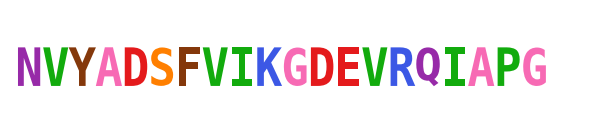

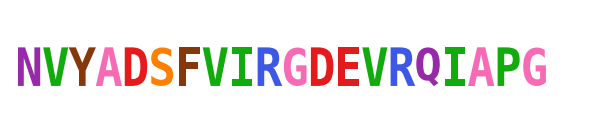

In [ ]:
# Sample sequences
sequences = [
    "NVYADSFVIKGDEVRQIAPG",
    "NVYADSFVIRGDEVRQIAPG",
    #"EGFNSYFPLQSYGFQPANG",
    #"EGFNSYFPLQSYGFEPTNG",
    #"EGFNSYFPLQSYGSQPTNG"
]


for seq in sequences:
    data_r21 = []
    for i, aa in enumerate(seq, start=399):
        data_r21.append({'Spike_position': i, 'Amino_Acid': aa})

    df_r21 = pd.DataFrame(data_r21)

    # Filter the dataframe to include only spike positions from 399 to 418
    df_filtered_r21 = df_r21[df_r21['Spike_position'].between(399, 418)]

    # Calculate the frequency of each amino acid at each spike position
    df_aggregated_r21 = df_filtered_r21.groupby(['Spike_position', 'Amino_Acid']).size().reset_index(name='Frequency')
    df_aggregated_r21['Frequency'] = df_aggregated_r21['Frequency'] / df_aggregated_r21['Frequency'].max()

    # Create the DMS logo plot
    fig, ax = dmslogo.draw_logo(
        df_aggregated_r21,
        x_col="Spike_position",
        letter_col="Amino_Acid",
        letter_height_col="Frequency",
        #title=f"DMS Logo Plot for sequence {seq}",
        addbreaks=True,
        heightscale=0.3,
        hide_axis=True
    )

    plt.show()



    Spike_AS_position Amino_Acid  ELISA_value
0                 399          N          2.0
1                 400          V          2.0
2                 401          Y          2.0
3                 402          A          2.0
4                 403          D          2.0
5                 404          S          2.0
6                 405          F          2.0
7                 406          V          2.0
8                 407          I          2.0
9                 408          K          9.2
10                408          R          4.0
11                409          G          2.0
12                410          D          2.0
13                411          E          2.0
14                412          V          2.0
15                413          R          2.0
16                414          Q          2.0
17                415          I          2.0
18                416          A          2.0
19                417          P          2.0
20                418          G  

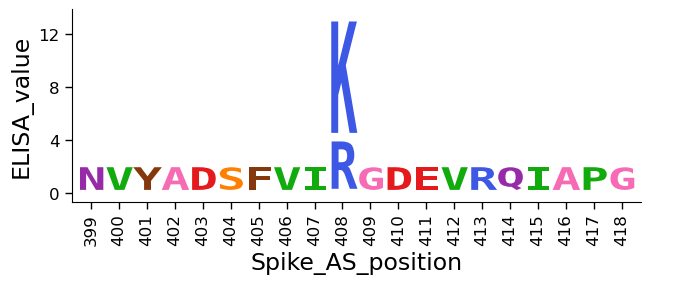

In [ ]:
import pandas as pd

# Define the sequences and starting position
sequences = ["NVYADSFVIKGDEVRQIAPG", "NVYADSFVIRGDEVRQIAPG"]
start_position = 399

# Create a list to hold the data
data = []

# Iterate over the sequences and positions
for seq in sequences:
    for i, aa in enumerate(seq):
        position = start_position + i
        data.append({"Spike_AS_position": position, "Amino_Acid": aa, "ELISA_value": 1})

# Handle the special case for position 408
data.append({"Spike_AS_position": 408, "Amino_Acid": "K", "ELISA_value": 8.2})
data.append({"Spike_AS_position": 408, "Amino_Acid": "R", "ELISA_value": 3.0})

# Create the DataFrame
df_peptides = pd.DataFrame(data)

# Aggregate the ELISA values for each Spike_AS_position and Amino_Acid combination
df_peptides = df_peptides.groupby(['Spike_AS_position', 'Amino_Acid'], as_index=False).agg({'ELISA_value': 'sum'})

# Display the DataFrame
print(df_peptides)

fig, ax = dmslogo.draw_logo(
        df_peptides,
        x_col="Spike_AS_position",
        letter_col="Amino_Acid",
        letter_height_col="ELISA_value",
        #title=f"DMS Logo Plot for sequence {seq}",
        addbreaks=True,
        heightscale=1,
    )
plt.show()



